# Component 1 - Transportable Array

## Import Modules and Data

In [162]:
%matplotlib inline

In [212]:
from haversine import haversine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import ipywidgets
import matplotlib.gridspec as gridspec
import cartopy
from matplotlib import animation
from IPython.display import Audio
import seaborn as sns
from scipy import signal

In [164]:
array_vals = pd.read_csv("data-readonly/transportable_array/data_tohoku_norm_transpose.csv", header=None)

In [165]:
## This code comes from Prof Turk. Translates our 4 hour time period into the time of day between 2:46pm and 6:46pm. 
v = pd.date_range("2:46PM", "6:46PM", freq="1s")
v -= v[0]
array_vals["time"] = v
array_vals.set_index("time", inplace=True)

In [166]:
date_range = pd.date_range("2:46PM", "6:46PM", freq="1s")

In [167]:
# Now bringing in longitude and latitudes of stations
locations = pd.read_csv("/srv/nbgrader/data/transportable_array/location.txt",
                        delimiter="\t", names =["longitude", "latitude", "a", "b"])
del locations["a"], locations["b"]
locations = locations.T
#locations

In [168]:
stations = pd.concat([locations, array_vals]) 
#stations.head()

## Calculating Distances with Haversine

In [169]:
# longitude and latitude of Tohoku quake c/o Google 
tohoku_quake = (38.3, 142.4)
station1 = stations[3][1], stations[3][0] # latitude then longitude
haversine(tohoku_quake, station1, miles = True)

#dist_from_quake = 
dists = []
for s in stations:
    station = stations[s][1], stations[s][0]
    dist = haversine(tohoku_quake, station, miles = True)
    dists.append(dist)
    
distances = pd.DataFrame(dists)
distances.columns = ['dist']
distances.sort_values(by = 'dist', inplace = True, ascending = True)
#... okay, getting late. Here, planning to... 
# 1. calcuate distance between stations and Tohoku quake
# 2. sort them in order of least to greatest distance, but need to also retain the original index.
# 3. Use this new order in the graphing code below.

## Dataframe with Stations, Distances, Coordinates, Time & Reading Values

In [170]:
test2 = stations.T
distances1 = distances
distOrder = pd.merge(distances1, left_index=True, right_index=True, right=test2)
distOrder.head()
testt = pd.DataFrame(distOrder)
testt.reset_index(inplace = True)
#testt

In [171]:
#Dropping the 'index' column, not the actual index
#testt.drop('index', axis = 1, inplace = True)
#testt.loc[0]

## Line Plot

In [172]:
######################################
#**** SEISMOGRAPH LINE PLOT ONLY ****#
######################################
@ipywidgets.interact(time = (0, 14400, 1), station = (0, 437, 1))
def make_plot(time = 2000, station = 0):
    i = 5
    plt.subplot(211)
    plt.plot(testt.loc[station][4:i+time].values)
    plt.xlim(0, 14000)
    plt.ylim(-1.0, 1.0)

interactive(children=(IntSlider(value=2000, description='time', max=14400), IntSlider(value=0, description='station', max=437), Output()), _dom_classes=('widget-interact',))

## Spectrogram

In [221]:
##############################################
#**** SEISMOGRAPH READINGS NORMALIZED(?) ****#
##############################################

testt.fillna(0, inplace = True)
@ipywidgets.interact(time = (0, 14400, 1), station = (0, 437, 1))
def make_plot(time = 2000, station = 0):
    i = 5
    vals = array_vals
    normalisedVals = ( vals - np.nanmin(vals) ) / ( np.nanmax(vals) - np.nanmin(vals) )
    normalisedVals = normalisedVals.astype(np.float)

    plt.hexbin(range(0, len(testt.loc[station][4:i+time].values)),
               testt.loc[station][4:i+time].values,
              vmin = normalisedVals.min().min(),
              vmax = normalisedVals.max().max(),
              cmap = 'viridis')
    plt.colorbar()

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7f59cb56e8d0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/opt/conda/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/opt/conda/lib/python3.6/wave.py", line 454, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


TypeError: 'Play' object is not callable

## Spectrogram (?) & Line Plot

In [174]:
################################
#**** SEISMOGRAPH READINGS ****#
################################

@ipywidgets.interact(time = (0, 14400, 1), station = (0, 437, 1))
def make_plot(time = 2000, station = 0):
    i = 5
    plt.subplot(211)
    plt.plot(testt.loc[station][4:i+time].values)
    plt.xlim(0, 14000)
    plt.ylim(-1.0, 1.0)
    
    vmin = array_vals.min().min() 
    vmax = array_vals.max().max()
    
    plt.subplot(212)
    plt.hexbin(range(0, len(testt.loc[station][4:i+time].values)), testt.loc[station][4:i+time].values, cmap = 'viridis', vmin = vmin, vmax = vmax)
    plt.colorbar()

interactive(children=(IntSlider(value=2000, description='time', max=14400), IntSlider(value=0, description='station', max=437), Output()), _dom_classes=('widget-interact',))

## Stations Map


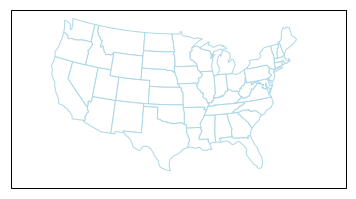

interactive(children=(IntSlider(value=0, description='station', max=437), Output()), _dom_classes=('widget-interact',))

In [175]:
##################################
#******* STATION LOCATOR ********# 
##################################

states = cartopy.io.shapereader.natural_earth(resolution='110m',
                                              category='cultural',
                                              name='admin_1_states_provinces_lakes_shp')
reader = cartopy.io.shapereader.Reader(states)
all_states = list(reader.records())
all_states[0]
geometries = [state.geometry for state in all_states]

fig = plt.figure()
ax1 = fig.add_subplot(111, projection = cartopy.crs.LambertConformal())
ax1.set_extent([-125, -66.5, 20, 50], cartopy.crs.Geodetic())
ax1.add_geometries(geometries, crs = cartopy.crs.PlateCarree(), facecolors = 'white', edgecolors = 'lightblue', zorder = 0)

#lat = testt[:]['latitude'].values
#lon = testt[:]['longitude'].values
@ipywidgets.interact(station = (0, 437, 1))
def plot_station(station = 0):
    scat = ax1.scatter(testt.loc[station]['longitude'], 
                testt.loc[station]['latitude'], 
                transform = cartopy.crs.Geodetic(), 
                s = 10, 
                c = 'k',
               zorder = 1)

In [176]:
states = cartopy.io.shapereader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_1_states_provinces_lakes_shp')
reader = cartopy.io.shapereader.Reader(states)
all_states = list(reader.records())
all_states[0]
geometries = [state.geometry for state in all_states]

## Component 1 Plots

In [216]:
@ipywidgets.interact(station = (0, 437, 1), time = (0, 14400, 1))
def make_plot(time = 0, station = 0):
    gs = gridspec.GridSpec(25, 10)
    fig = plt.gcf()
    fig = plt.figure(figsize=(25, 10))
    ax1 = fig.add_subplot(gs[:, :5], projection = cartopy.crs.LambertConformal())
    ax2 = fig.add_subplot(gs[4:12, 6:])
    ax3 = fig.add_subplot(gs[13:21, 6:])

    i = 5
    ax2.plot(testt.loc[station][4:i+time].values)
    ax2.set_xlim(0, 14000)
    ax2.set_ylim(-1.0, 1.0)
    
    vmin = array_vals.min().min() 
    vmax = array_vals.max().max()
    
    i = 5
    vals = array_vals
    normalisedVals = ( vals - np.nanmin(vals) ) / ( np.nanmax(vals) - np.nanmin(vals) )
    normalisedVals = normalisedVals.astype(np.float)

    ax3.hexbin(np.arange(14401), np.abs(testt.loc[station][4:].values), bins = 'log')
    #fig.colorbar(ax3)
    
    ax1.set_extent([-125, -66.5, 20, 50], cartopy.crs.Geodetic())
    ax1.add_geometries(geometries, crs = cartopy.crs.PlateCarree(), facecolors = 'lightblue', edgecolors = 'blue', zorder = 0)

    ax1.scatter(testt.loc[station]['longitude'], 
            testt.loc[station]['latitude'], 
            transform = cartopy.crs.Geodetic(), 
            s = 35, 
            c = 'k',
            zorder = 1)
    
    # Audio
    normed = (array_vals[0] - array_vals[0].min())/(array_vals[0].max() - array_vals[0].min()) * 2 - 1
    a = Audio(normed, rate=44100/8)
    #fig.add_subplot(a)

interactive(children=(IntSlider(value=0, description='time', max=14400), IntSlider(value=0, description='station', max=437), Output()), _dom_classes=('widget-interact',))

In [219]:
normed = (array_vals[0] - array_vals[0].min())/(array_vals[0].max() - array_vals[0].min()) * 2 - 1
a = Audio(normed, rate=44100/8)
a

TypeError: '<=' not supported between instances of 'NoneType' and 'int'

## Spectrogram


In [206]:
#x = testt.loc[station][4:].values
y = np.arange(14401)

ind = list(testt.columns)
new = testt.loc[0][ind[4:]]

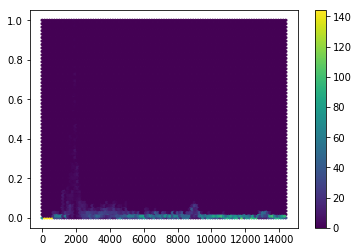

In [210]:
plt.hexbin(y, np.abs(new))
plt.colorbar()

In [224]:
@ipywidgets.Dropdown?

In [ ]:
@ipywidgets.Dropdown

In [ ]:
@ipywidgets.Password